## Burrows's Delta

In [1]:
path = './corpus/a/'

In [2]:
import re

def get_tokens(filename):
    '''open text file and return list of tokens'''
    # text = open(filename, 'r').read().lower()
    f = open(filename, 'r') # open file
    text = f.read() # read file
    text = text.lower() # lower-case text
    tokens = [word for word in re.split('\W', text) if word != ''] # remove punctuation
    return tokens

In [3]:
def get_features(samples):
    tokens = []
    for sample in samples:
        tokens += get_tokens(path + sample + '.txt')
    types = list(set(tokens)) # create unordered list of unique words
    tmp = dict.fromkeys(types, 0) # create temporary dictionary, initialize counts to 0
    for token in tokens: tmp[token] += 1 # count words
    # re-order words in temporary dictionary numerically by descending frequency
    # re-order words with same frequency alphabetically
    features = { 
        key: value for key, value in sorted(tmp.items(),
        key = lambda item: (-item[1], item[0]))
    }
    return features

In [4]:
import pandas as pd

def get_counts(features, samples):
    columns = {}
    for sample in samples:
        columns[sample] = []
        tmp = get_features([sample])
        for feature in features:
            columns[sample].append(tmp.get(feature, 0))
    return pd.DataFrame(columns, index = features)

In [5]:
def get_lengths(samples):
    filenames = [path + sample + '.txt' for sample in samples]
    lengths = {}
    for i in range(len(samples)):
       lengths[samples[i]] = len(get_tokens(filenames[i]))
    return pd.DataFrame(lengths, index = ['words'])

In [6]:
limit = 4 # 4 most frequent words (MFWs)
samples = ['Gratian1', 'dePen', 'Gratian2']
unknown = 'Gratian0'
features = get_features(samples)
mfws = list(features.keys())[:limit]
counts = get_counts(mfws, [unknown] + samples)
lengths = get_lengths([unknown] + samples)
frequencies = (counts / lengths.values) * 1000
means = frequencies[samples].mean(axis = 1).to_frame('mean')
standard_deviations = frequencies[samples].std(axis = 1).to_frame('std')
z_scores = (frequencies - means.values) / standard_deviations.values
# pd.options.display.float_format = '{:,.4f}'.format
f = open('./burrows.md', 'w')
f.write("---\nauthor: Paul Evans\ntitle: Chapter 4\nsubtitle: Burrows's Delta Tables\n---\n\n") # YAML header
pd.options.display.float_format = '{:,.4f}'.format
f.write(z_scores.round(4).to_markdown() + '\n\n')
z_scores

,Gratian0,Gratian1,dePen,Gratian2
in,-2.8702,-0.4342,-0.7095,1.1437
non,-6.5491,-0.0361,1.0176,-0.9814
et,-3.2375,-0.9786,1.0201,-0.0414
est,-3.5264,0.4179,0.7233,-1.1412


|     |   Gratian0 |   Gratian1 |   dePen |   Gratian2 |
|:----|-----------:|-----------:|--------:|-----------:|
| in  |    -2.8702 |    -0.4342 | -0.7095 |     1.1437 |
| non |    -6.5491 |    -0.0361 |  1.0176 |    -0.9814 |
| et  |    -3.2375 |    -0.9786 |  1.0201 |    -0.0414 |
| est |    -3.5264 |     0.4179 |  0.7233 |    -1.1412 |

---

The examples presented in the previous section are suggestive of ways in which differences between the frequencies of occurrence of common words in samples from a corpus of texts can be quantified in statistically meaningful units (standard deviations or values of z) and combined to represent the distance between those samples.  This technique is, however, of limited value so long as we are restricted to the two, or at most three, dimensions the human mind is capable of visualizing. In 2001, John F. Burrows (d.2019) of the University of Newcastle, Australia, proposed a generalization that gets around the limitation on the number of features to two or three by averaging z-score distance measurements of word frequency data for any number of features. This has the effect of collapsing distance measurements in an arbitrary number of dimensions into a single metric. Burrows called this metric the Delta, and it is now generally referred to as Burrows's Delta ($\Delta_B$). Expositions of Burrows's Delta sometime fail to make a clear enough distinction between the metric $\Delta_B$ and the authorship attribution methodology in which Burrows applied it. The metric is not the methodology.

Attempts to attribute authorship are typically undertaken in scenarios where there is a large (enough) number of texts securely attributable to a known author, and a text, or at most a small number of texts, of unknown authorship. The attempt is then made to attribute the unknown text to one of the known authors, or to rule out such an attribution. Take the *Federalist* as an example. There are numbers of the *Federalist* of disputed or unknown attribution, a small and well-defined number of candidates for authorship---Hamilton, Jay, Madison---to whom those numbers might be attributed, and securely attributed samples from each of the candidates, conveniently enough from the same work.

Burrows's methodology assumes just such a scenario. He began by identifying the most frequent words (MFWs) in the corpus of comparison texts securely attributed to known authors. In Burrows's published descriptions of his methodology, he typically used all of the 30 most frequent words in the corpus of attributed comparison texts without distinguishing between function and content words. He then tabulated the number of occurrences of the most frequent words in each of the sample texts in the comparison corpus and normalized their frequency of occurrence as a percentage. Burrows then used the frequency data collected from the comparison texts to calculate a mean frequency of occurrence and sample standard deviation for each of the MFWs or features.

It is important to emphasize that the mean frequency of feature occurrence calculated at this stage of Burrows's algorithm and subsequently used to calculate the sample standard deviation for each feature is **not** the overall mean frequency across the corpus of attributed comparison text samples. Instead, the comparison corpus feature mean is calculated by averaging the normalized (percentage) frequency for each feature across all of the text samples in the attributed comparison corpus, without concern for differences in size (word count) between the samples. To refer back to the example presented in the previous section as part of the two-dimensional visualization demonstration, we did **not** use the **overall** mean frequency of *in* across the three samples Gratian1, dePen, and Gratian2, (2,113 occurrences out of 81,049 words or 26.0706 per 1,000), but rather the mean of the normalized frequencies of *in* for each of the samples (the mean of 25.5673, 24.9975, and 28.8320, or 26.4656 occurrences per 1,000). **(mean of means)**

After calculating the mean of means and sample standard deviation for each of the features (MFWs), Burrows then converted the normalized (percentage) frequencies of occurrence for each feature in each sample in the comparison corpus to z-scores by subtracting the mean of means from the frequency and dividing the positive or negative difference by the standard deviation for the feature. At this point, Burrows turned his attention to the unattributed text, tabulating all occurrences of the 30 MFWs for which data had been collected from the comparison texts, then normalizing the word counts by converting them to percentage frequencies of occurrence. Burrows then converted the normalized frequencies for each feature in the unattributed test sample to z-scores based on the values for the mean of means and sample standard deviation derived from the feature frequencies in the attributed comparison corpus samples.

With these preliminaries out of the way, Burrows then calculated the value of the Delta by taking the average (arithmetic mean) of the absolute value of the differences between the z-score for a given feature (MFW) for the unattributed test sample and each of the comparison samples in the corpus of attributed texts. In Burrows's interpretation, the comparison test sample from the attributed corpus with the lowest Delta with respect to the unattributed test sample was most likely to share a common author with it.

It is not possible to apply Burrow's methodology in the case of the *dicta* from Gratian's *Decretum* without modification. As the survey in Chapter 3 above indicated, near-contemporaries knew next to nothing about Gratian. Perhaps most notably, although Gratian was thought to have been a teacher, no one in the generation following made an unambiguous claim to have been his student. There are no other writings securely, or even insecurely, attributed to him. Fortunately, Burrows's Delta can be readily adapted to the particular situation in which we find ourselves, where there are no other texts attributed to Gratian with which we can compare, for example, the hypothetical case statements (*themata*) or second-recension *dicta*.

Although other distance methods of authorship attribution have been proposed since,[@evert_understanding_2017] Burrows's Delta is widely accepted in the scholarly literature of the field of computational linguistics, and it will therefore be used as the basis for the demonstrations in this section.

The first experiment will be a comparison of four subcorpora, Gratian0 (the hypothetical case statements or *themata*), Gratian1 (the first-recension *dicta* excluding the *dicta* from *de Penitentia*), dePen (first- and second-recension *dicta* from *de Penitentia*), and Gratian2 (the second-recension *dicta* excluding the *dicta* from *de Penitentia*), using the frequencies of occurrence of the four most frequent words (MFWs) in Gratian's *dicta* as the basis for comparison. We will hypothesize that the subcorpus containing the hypothetical case statements (*themata*) is the work of an unknown author, and will treat the other three subcorpora as making up a corpus of works by a known author. Using four subcorpora and four features, where every feature analyzed is represented in a different dimension, demonstrates that z-score distance methods can be extended to cases in which the number of dimensions is greater than three. It also has the advantage of making the solution compact enough to allow readers to follow along and reassure themselves of the mathematical validity of all of the intermediate steps leading to the final result.

The first experiment resumes directly where the two-dimensional visualization demonstration left off, so all of the function definitions and variable values in force at the conclusion of that demonstration are still valid. In particular, this experiment inherits the z-scores for all of the four most frequent words (MFWs). While we disregarded the data for the third and fourth most frequent words (*et* and *est*) for the purpose of the visualization demonstration, they will be fully taken into account here. (Remember that the values for mean and standard deviations used to derive the z-scores were calculated without reference to the Gratian0 sample here being treated as the unknown).

First, split the z-scores into two new dataframes, one for the test sample Gratian0, assumed for the purpose of this experiment to be the work of an unknown author:

In [7]:
test = z_scores[[unknown]]
f.write(test.round(4).to_markdown() + '\n\n')
test

,Gratian0
in,-2.8702
non,-6.5491
et,-3.2375
est,-3.5264


|     |   Gratian0 |
|:----|-----------:|
| in  |    -2.8702 |
| non |    -6.5491 |
| et  |    -3.2375 |
| est |    -3.5264 |

the other for the comparison samples Gratian1, dePen, and Gratian2, assumed for the purpose of this experiment to represent the work of known authors:

In [8]:
corpus = z_scores[samples]
f.write(corpus.round(4).to_markdown() + '\n\n')
corpus

,Gratian1,dePen,Gratian2
in,-0.4342,-0.7095,1.1437
non,-0.0361,1.0176,-0.9814
et,-0.9786,1.0201,-0.0414
est,0.4179,0.7233,-1.1412


|     |   Gratian1 |   dePen |   Gratian2 |
|:----|-----------:|--------:|-----------:|
| in  |    -0.4342 | -0.7095 |     1.1437 |
| non |    -0.0361 |  1.0176 |    -0.9814 |
| et  |    -0.9786 |  1.0201 |    -0.0414 |
| est |     0.4179 |  0.7233 |    -1.1412 |

The formula used to calculate Burrows's Delta is:

$\Delta_B = \frac{1}{N}\sum_{i = 1}^N|z_i(t) - z_i(c)|$

![Burrows's Delta](JPGs/Burrows.jpg)

It is easiest to deal with the formula in two steps, first evaluating the expression $|z_i(t) - z_i(c)|$. Note that because we take the absolute value of the result, the order of operands on either side of the subtraction operator '-' does not matter. For each of the three columns (Gratian1, dePen, and Gratian2) in the *corpus* dataframe, subtract the z-score in each row from the z-score in the same row of the *test* (Gratian0) dataframe, take the absolute value, and record the result in the corresponding column and row of the *differences* dataframe. For example, the z-score for *non* in *test* (Gratian0) is -6.5491, the z-score for *non* in the Gratian1 column of *corpus* is -0.0361, so the absolute value of the difference recorded in the *non* row of the Gratian1 column of *differences* would be 6.5130.

In [9]:
differences = (test.values - corpus).abs()
f.write(differences.round(4).to_markdown() + '\n\n')
differences

,Gratian1,dePen,Gratian2
in,2.4360,2.1606,4.0139
non,6.5130,7.5667,5.5677
et,2.2589,4.2576,3.1961
est,3.9443,4.2497,2.3852


|     |   Gratian1 |   dePen |   Gratian2 |
|:----|-----------:|--------:|-----------:|
| in  |     2.436  |  2.1606 |     4.0139 |
| non |     6.513  |  7.5667 |     5.5677 |
| et  |     2.2589 |  4.2576 |     3.1961 |
| est |     3.9443 |  4.2497 |     2.3852 |

Given the layout of the *differences* dataframe in which we have stored the intermediate results, the part of the formula we deferred dealing with ($\frac{1}{N}\sum_{i = 1}^N$) is simply a notationally exact way of indicating that we are to take the average (arithmetic mean) of the values in each of the columns, and record the resulting value of $\Delta_B$ in the corresponding column of the *deltas* dataframe.

(**Burrows's Delta measures Manhattan Distance.**)

The seemingly simple act of taking the arithmetic mean (average) of the z-score distances between the samples for each feature has an interesting and non-intuitive implication. It was mentioned in passing in the previous section on visualization that plotting the z-score coordinates of word frequencies invokes the tacit assumption that the axes are in fact perpendicular to one another, an assumption that is at least potentially open to challenge. Burrows's Delta generalizes this assumption into an arbitrary number of dimension. The scholarly literature on authorship attribution methods describes distance metrics such as Burrows's Delta as measuring 'Manhattan Distance'. The analogy is to walking or driving from a starting to an ending point through a space in which the street have been laid out at right angles to one another, like Manhattan.

In [10]:
row = (differences.mean(axis = 0)).to_frame(unknown).transpose()
f.write(row.round(4).to_markdown() + '\n\n')
row

,Gratian1,dePen,Gratian2
Gratian0,3.7880,4.5586,3.7907


|          |   Gratian1 |   dePen |   Gratian2 |
|:---------|-----------:|--------:|-----------:|
| Gratian0 |      3.788 |  4.5586 |     3.7907 |

The Gratian1 subcorpus is just slightly closer than the Gratian2 subcorpus to the unknown Gratian0 test case, with values of Delta for both rounding to 3.79. A candidate is defined as being *closest* to the unknown when it has the lowest mean of the absolute values of the differences between the z-scores for the unknown and the candidate.But as Burrows pointed out, one candidate will always have the lowest $\Delta_B$, so that in itself is not enough to make or to rule out an attribution of authorship. We will need further information before we can provide any kind of interpretation for the result. The most we can say based on this result is that the hypothetical case statements are less likely to have been written by the author of the *dicta* in *de Penitentia* than by the authors of either the first- or second-recension *dicta*.

The second experiment is a variation on the first, in which a 3881-word sample made up of seven extended passages from the pseudo-Augustinian *De vera et falsa penitentia* quoted by Gratian in *de Penitentia* are substituted for the 3605-word sample containing the hypothetical case statements.[^b3] As noted in Chapter 0 above, Gratian can be said with a high degree of confidence **not** to be the author of *De vera et falsa penitentia*. The authors are strongly distinguished by their choice of post-positive conjunctions: Gratian has a preference for *autem*, while pseudo-Augustine has an even stronger preference for *enim*. Substituting the pseudo-Augustinian sample in place of the case statements demonstrates the kinds of results to be expected from Burrows's Delta in a situation in which an attribution of authorship can reasonably be ruled out.

In [11]:
limit = 4 # 4 most frequent words (MFWs)
samples = ['Gratian1', 'dePen', 'Gratian2']
unknown = 'psAug'
features = get_features(samples)
mfws = list(features.keys())[:limit]
counts = get_counts(mfws, [unknown] + samples)
lengths = get_lengths([unknown] + samples)
frequencies = (counts / lengths.values) * 1000
means = frequencies[samples].mean(axis = 1).to_frame('mean')
standard_deviations = frequencies[samples].std(axis = 1).to_frame('std')
z_scores = (frequencies - means.values) / standard_deviations.values
test = z_scores[[unknown]]
corpus = z_scores[samples]
differences = (test.values - corpus).abs()
row = (differences.mean(axis = 0)).to_frame(unknown).transpose()
f.write(row.round(4).to_markdown() + '\n\n')
row

,Gratian1,dePen,Gratian2
psAug,2.6456,1.7373,3.4318


|       |   Gratian1 |   dePen |   Gratian2 |
|:------|-----------:|--------:|-----------:|
| psAug |     2.6456 |  1.7373 |     3.4318 |

The third experiment extends the first by treating each of the subcorpora, Gratian0, Gratian1, dePen, and Gratian2 sequentially as the work of an unknown author, and the other three subcorpora as constituting a corpus of works by a known author. This is an attempt to demonstrate the adaptation of Burrows's technique in a circumstance in which there are no securely attributed comparison texts outside of the corpus, and in which there is some reason to suspect that there are multiple authors at work within the corpus.

In [12]:
path = './corpus/a/'

# author candidates, e.g. Gratian 1, the Master of Penance, Gratian 2, etc.
candidates = ['Gratian0', 'Gratian1', 'dePen', 'Gratian2']
deltas = pd.DataFrame(columns = candidates)
limit = 4 # 4 most frequent words (MFWs)
for candidate in candidates:
    unknown = candidate
    samples = candidates[:]
    samples.remove(unknown)
    features = get_features(samples)
    mfws = list(features.keys())[:limit]
    counts = get_counts(mfws, [unknown] + samples)
    lengths = get_lengths([unknown] + samples)
    frequencies = (counts / lengths.values) * 1000
    means = frequencies[samples].mean(axis = 1).to_frame('mean')
    standard_deviations = frequencies[samples].std(axis = 1).to_frame('std')
    z_scores = (frequencies - means.values) / standard_deviations.values
    test = z_scores[[unknown]]
    corpus = z_scores[samples]
    differences = (test.values - corpus).abs()
    row = (differences.mean(axis = 0)).to_frame(unknown).transpose()
    deltas = deltas.append(row)
# csv = open('./CSVs/deltas.csv', 'w')
# csv.write(deltas.to_csv())
# csv.close()
f.write(deltas.round(4).to_markdown() + '\n\n')
deltas

,Gratian0,Gratian1,dePen,Gratian2
Gratian0,nan,3.7880,4.5586,3.7907
Gratian1,1.4361,nan,0.3628,0.5453
dePen,1.9873,0.4515,nan,0.7673
Gratian2,1.7185,0.6278,0.7905,nan


|          |   Gratian0 |   Gratian1 |    dePen |   Gratian2 |
|:---------|-----------:|-----------:|---------:|-----------:|
| Gratian0 |   nan      |     3.788  |   4.5586 |     3.7907 |
| Gratian1 |     1.4361 |   nan      |   0.3628 |     0.5453 |
| dePen    |     1.9873 |     0.4515 | nan      |     0.7673 |
| Gratian2 |     1.7185 |     0.6278 |   0.7905 |   nan      |

Considering the results of the first three experiments together, we can start to form some very preliminary conclusions. Based on the values for $\Delta_B$ in the table above, the most likely attribution is that the first-recension *dicta* (Gratian1) and the *dicta* from *de Penitentia* (dePen) have the same author. It is less likely that the first-recension *dicta* (Gratian1) and the second-recension *dicta* (Gratian2) have the same author. It is less likely still that the *dicta* from *de Penitentia* and the second-recension *dicta* have the same author. It is much less likely that the case statements (Gratian0) have the same author as either the first- (Gratian1) or second-recension (Gratian2) *dicta*. Finally, the least likely attribution is that the case statements (Gratian0) have the same author as the *dicta* from *de Penitentia*.

---

In [13]:
path = './corpus/a/'

# author candidates, e.g. pseudo-Augustine, Gratian 1, the Master of Penance, Gratian 2, etc.
candidates = ['psAug', 'Gratian1', 'dePen', 'Gratian2']
deltas = pd.DataFrame(columns = candidates)
limit = 4 # 4 most frequent words (MFWs)
for candidate in candidates:
    unknown = candidate
    samples = candidates[:]
    samples.remove(unknown)
    features = get_features(samples)
    mfws = list(features.keys())[:limit]
    counts = get_counts(mfws, [unknown] + samples)
    lengths = get_lengths([unknown] + samples)
    frequencies = (counts / lengths.values) * 1000
    means = frequencies[samples].mean(axis = 1).to_frame('mean')
    standard_deviations = frequencies[samples].std(axis = 1).to_frame('std')
    z_scores = (frequencies - means.values) / standard_deviations.values
    test = z_scores[[unknown]]
    corpus = z_scores[samples]
    differences = (test.values - corpus).abs()
    row = (differences.mean(axis = 0)).to_frame(unknown).transpose()
    deltas = deltas.append(row)
deltas

,psAug,Gratian1,dePen,Gratian2
psAug,nan,2.6456,1.7373,3.4318
Gratian1,1.0228,nan,0.4653,0.9325
dePen,0.5178,0.4733,nan,1.3453
Gratian2,5.2005,3.3574,4.2857,nan


---

The fourth and final experiment will compare the thirty most frequent words (MFWs) across fourteen subcorpora: cases (C.1-36 d.init.), laws (D.1-20 R1 *dicta*), orders1 (D.21-80 R1 *dicta*), orders2 (D.81-101 R1 *dicta*), simony (C.1 R1 *dicta*), procedure (C.2-6 R1 *dicta*), other1 (C.7-10 R1 *dicta*), other2 (C.11-15 R1 *dicta*), monastic (C.16-20 R1 *dicta*), other3 (C.21-22 R1 *dicta*), heresy (C.23-26 R1 *dicta*), marriage (C.27-36 R1 *dicta*), penance (R1 and R2 *dicta* from *de Penitentia*), and second (all R2 *dicta*, excluding those from *de Penitentia*).[<sup>4</sup>](#fn4) For each of the fourteen subcorpora, we will hypothesize each subcorpus in turn to be the work of an unknown author, and will treat the other thirteen subcorpora as composing a corpus of works by a known author. The scale of the fourth experiment is similar to that of the experiments carried out by John Burrows and David Hoover, the pioneers of the technique, but makes it impractical to show intermediate results at every step in the process.

<span id="fn4">The division of the first-recension (R1) dicta into twelve sections follows the division of Gratian’s Decretum proposed by Alfred Beyer in *Lokale Abbreviationen Des Decretum Gratiani: Analyse Und Vergleich Der Dekretabbreviationen "Omnes Leges Aut Divine" (Bamberg), "Humanum Genus Duobus Regitur" (Pommersfelden) Und "de His Qui Intra Claustra Monasterii Consistunt" (Lichtenthal, Baden-Baden)*, Bamberger Theologische Studien ; Bd. 6 (Frankfurt am Main ; PLang, 1998), 17-18.</span>

In [14]:
path = './corpus/b/'

candidates = ['cases', 'laws', 'orders1', 'orders2', 'simony', 'procedure', 'other1', 'other2', 'monastic', 'other3', 'heresy', 'marriage', 'penance', 'second']
deltas = pd.DataFrame(columns = candidates)
limit = 30 # 30 most frequent words (MFWs)
for candidate in candidates:
    unknown = candidate
    samples = candidates[:]
    samples.remove(unknown)
    features = get_features(samples)
    mfws = list(features.keys())[:limit]
    counts = get_counts(mfws, [unknown] + samples)
    lengths = get_lengths([unknown] + samples)
    frequencies = (counts / lengths.values) * 1000
    means = frequencies[samples].mean(axis = 1).to_frame('mean')
    standard_deviations = frequencies[samples].std(axis = 1).to_frame('std')
    z_scores = (frequencies - means.values) / standard_deviations.values
    test = z_scores[[unknown]]
    corpus = z_scores[samples]
    differences = (test.values - corpus).abs()
    row = (differences.mean(axis = 0)).to_frame(unknown).transpose()
    deltas = deltas.append(row)
# csv = open('./CSVs/deltas.csv', 'w')
# csv.write(deltas.to_csv())
# csv.close()
f.write(deltas[['cases', 'laws', 'orders1', 'orders2', 'simony', 'procedure', 'other1']].round(4).to_markdown() + '\n\n')
f.write(deltas[['other2', 'monastic', 'other3', 'heresy', 'marriage', 'penance', 'second']].round(4).to_markdown() + '\n\n')
f.close()
deltas 


,cases,laws,orders1,orders2,simony,procedure,other1,other2,monastic,other3,heresy,marriage,penance,second
cases,nan,2.2765,1.9247,2.0252,1.9637,1.9545,1.5714,2.2782,1.7622,2.3628,1.8717,1.8923,1.8589,1.6334
laws,2.1410,nan,1.2490,1.5020,1.4633,1.3147,1.4223,1.4369,1.1931,1.4345,1.1875,1.1924,1.6218,1.2323
orders1,1.6184,1.0949,nan,1.1223,0.9685,0.8843,1.0499,1.1109,0.8693,1.2397,0.8267,1.0124,0.7505,0.7777
orders2,1.8982,1.5244,1.2686,nan,1.3820,1.6840,1.4149,1.6873,1.4492,1.6208,1.4198,1.4526,1.5523,1.3195
simony,1.6667,1.3491,0.9772,1.2195,nan,0.8878,1.1304,1.1287,1.0413,1.1711,0.5900,0.9166,0.9059,1.0863
procedure,1.6187,1.1991,0.8920,1.5095,0.8789,nan,1.0790,1.1223,0.8210,1.0726,0.6569,0.9993,0.8818,0.9852
other1,1.3353,1.3000,1.0619,1.2722,1.1383,1.0753,nan,1.2792,0.9649,1.3054,0.9960,1.0853,1.3272,0.8152
other2,1.9416,1.3233,1.0913,1.6291,1.1386,1.1090,1.2963,nan,0.7979,1.0346,1.0592,0.6540,0.8633,1.0961
monastic,1.4555,1.0451,0.8554,1.2676,1.0114,0.7986,0.9300,0.7429,nan,1.0578,0.7602,0.6611,0.7999,0.7799
other3,2.0705,1.3388,1.2890,1.5146,1.1997,1.1057,1.3497,0.9505,1.1229,nan,1.1209,0.7121,1.1521,1.3067


Because of the scale of the experiment, the results can be somewhat difficult to read, but are entirely consistent with those obtained in the previous simplified experiments. They are divided into two tables to allow them to be represented on the printed page, but should be imagined as a single table, with the second table extending the first table to the right. The first column of each row contains the name of the subcorpus hypothesized to be the work of an unknown author. The previously obtained results from the simplified demonstration examples lead us to expect that the cases subcorpus corresponding to the 36 hypothetical case statements or *themata* will have highest value for Burrows's Delta in each row. Remember that the cases subcorpus having the highest Delta value in a given row indicates that it is the *least* likely to have the same author as the subcorpus indicated in the first column and hypothesized to be the work of an unknown author.

Disregard the first row---we are not interested in the Delta distance of the cases subcorpus from itself. Read each row starting at the second, comparing the value for the Delta distance between the subcorpus of unknown authorship and the cases subcorpus with the Delta values for each of the other subcorpora. Taking the second row of each table as an example, the value for the Delta distance between the laws and cases subcorpora is 2.141, which is greater than NaN, 1.249, 1.502, 1.4633, 1.3147, 1.4223 in the first table, and continuing on to the corresponding row in the second table, is also greater than 1.4369, 1.1931, 1.4345, 1.1875, 1.1924, 1.6218, and 1.2323. (In each row, the entry corresponding to the Delta distance between the subcorpus of unknown authorship and itself is undefined, and is indicated by "NaN", an conventional abbreviation in numerical computing for "Not a Number".)

For each of the thirteen subcorpora excluding cases, the value for the Burrows's Delta distance between that subcorpus and the cases subcorpus is the highest in the row. In only one row are there Delta values that are even close to the value for the cases subcorpus: for the other1 subcorpus (first-recension *dicta* from *Causae* 7-10), the Delta value for the cases subcorpus is 1.3353, while the Delta values for laws (first-recension *dicta* from the *Tractatus de legibus*), other3 (first-recension *dicta* from *Causae* 21-22), and penance (first- and second-recension *dicta* from *de Penitentia*) are 1.3, 1.3054, and 1.3272 respectively. Even in this case, the Delta value for the cases subcorpus indicates that it is the *least* likely of any of the subcorpora in the row to share an author in common with the other1 subcorpus.

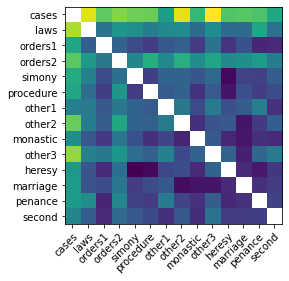

In [15]:
import matplotlib.pyplot as pp
import numpy as np

fig, ax = pp.subplots()
im = ax.imshow(deltas)
ax.set_xticks(np.arange(len(candidates)))
ax.set_yticks(np.arange(len(candidates)))
ax.set_xticklabels(candidates)
ax.set_yticklabels(candidates)
pp.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(candidates)):
    for j in range(len(candidates)):
        # text = ax.text(j, i, deltas.iloc[i,j], ha="center", va="center", color="w")
        pass
pp.show()